In [1]:
import numpy as np
import networkx as nx
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import geopandas as gpd
from shapely.geometry import Point
import time

In [2]:
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

path_cases = 'data/asignacion_tapas.csv'
cases = pd.read_csv(path_cases, sep=';')

G = nx.DiGraph()

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
    
N = l

W = [0 for u in range(N)]
C = [0 for u in range(N)]

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']
        C[u] = float(cases[cases['ID'] == _id[u]].iloc[0]['infectados'].replace(',', '.'))

In [3]:
def get_vals(G, V_, u):
    
    if V_[u] == 1:
        return 0, 0, 0
    
    V = V_.copy()
    
    s = 1; w = W[u]; c = C[u];
    Q = deque([u]); V[u] = 1
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s += 1; w += W[v];
                c += C[v]; V[v] = 1
                Q.append(v)
    return s, w, c

def get_size_reduce(G, V_, S, u):
    
    if V_[u] == 1:
        return 0
    
    if S[u] <= 200:
        return 1
    
    V = V_.copy()
    
    s = 1; V[u] = 1
    Q = deque([u]);
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s += 1; V[v] = 1
                if S[v] > 200:
                    Q.append(v)
    return s

def get_size_ignore(G, u_):
    
    if u_ == 744:
        return N
    
    V = [0] * N
    
    s = N - 1; V[744] = 1
    Q = deque([744]);
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v != u_:
                s -= 1; V[v] = 1
                Q.append(v)
    return s

def get_C(G, V_, u):
    
    if V_[u] == 1:
        return []
    
    V = V_.copy()
    
    s = [(u, C[u])]
    Q = deque([u]); V[u] = 1
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s.append((v, C[v]))
                V[v] = 1
                Q.append(v)
    return s

def get_ideal(G, V_, u):
    
    if V_[u] == 1:
        return []
    
    V = V_.copy()
    s = [u];  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s.append(v)
                V[v] = 1; Q.append(v)
    
    return s

In [11]:
DM = {i: -1 for i in range(50)}
Dm = {i: -1 for i in range(50)}
VM = {i: 0 for i in range(50)}
Vm = {i: 1e10 for i in range(50)}

SS = [0] * N; WW = [0] * N; CC = [0] * N
for u in range(N):
    SS[u], WW[u], CC[u] = get_vals(G, [0] * N, u)
    
SR = [0] * N; SI = [0] * N; revise = []
for u in range(N):
    SR[u] = get_size_reduce(G, [0] * N, WW, u)
    SI[u] = get_size_ignore(G, u)
    if SI[u] / SS[u] >= 0.9 and WW[u]:
        if 100 * (CC[u] / WW[u]) > VM[SR[u] // 100]:
            VM[SR[u] // 100] = 100 * (CC[u] / WW[u])
            DM[SR[u] // 100] = u
        if 100 * (CC[u] / WW[u]) < Vm[SR[u] // 100]:
            Vm[SR[u] // 100] = 100 * (CC[u] / WW[u])
            Dm[SR[u] // 100] = u

In [12]:
for i in range(2, 11):
    print(i, "   ", end="")
    if Dm[i] != -1:
        print(Dm[i], "-", _id[Dm[i]], ": ", Vm[i])
    else:
        print("----")

2    416 - 132050 :  0.028941471857571243
3    2444 - 14229 :  0.04961565959983945
4    3295 - 15084 :  0.03760940044668655
5    3304 - 15093 :  0.03191432404564268
6    ----
7    ----
8    ----
9    2071 - 13854 :  0.08245890051532653
10    ----


In [13]:
for i in range(2, 11):
    print(i, "   ", end="")
    if DM[i] != -1:
        print(DM[i], "-", _id[DM[i]], ": ", VM[i])
    else:
        print("----")

2    2140 - 13923 :  0.43593730583888723
3    1435 - 13212 :  0.2729541856137525
4    1431 - 13208 :  0.38826393673987725
5    3876 - 15671 :  0.03241659587479817
6    ----
7    ----
8    ----
9    875 - 13587 :  0.08438414445951524
10    ----


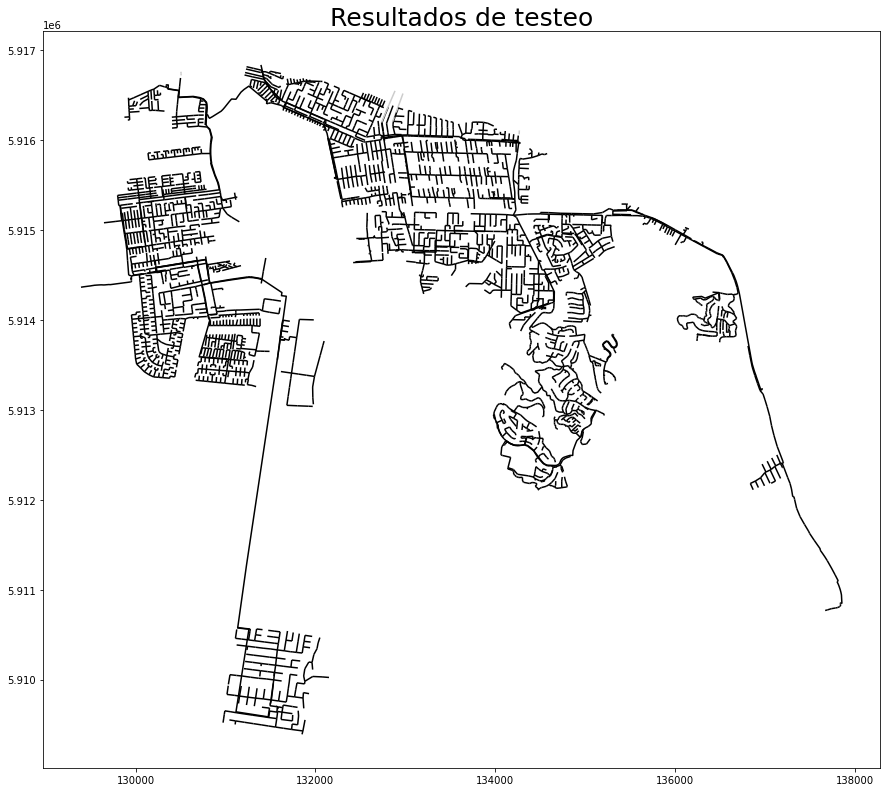

In [8]:
path = 'data/corrected_dijkstra.csv'
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
geometry['color'] = 10
for u in range(N):
    geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = 0
f, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Resultados de testeo", fontsize=25)
ax = geometry.plot(ax = ax, column = 'color',
            figsize=(15, 15),
            cmap = 'nipy_spectral',)

plt.show()

def plot_sample_tree(G, N, sample, geom):
    
    geometry = geom.copy()
    
    V = [0] * N; C = [-1] * N
    
    i = 0
    for u in sample[::-1]:
        ideal = get_ideal(G, V, u)
        for v in ideal:
            V[v] = 1
            C[v] = i
        i += 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        if C[u] != -1:
            geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No cubierto \n ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
    plt.savefig('foo.png')
    plt.show()  

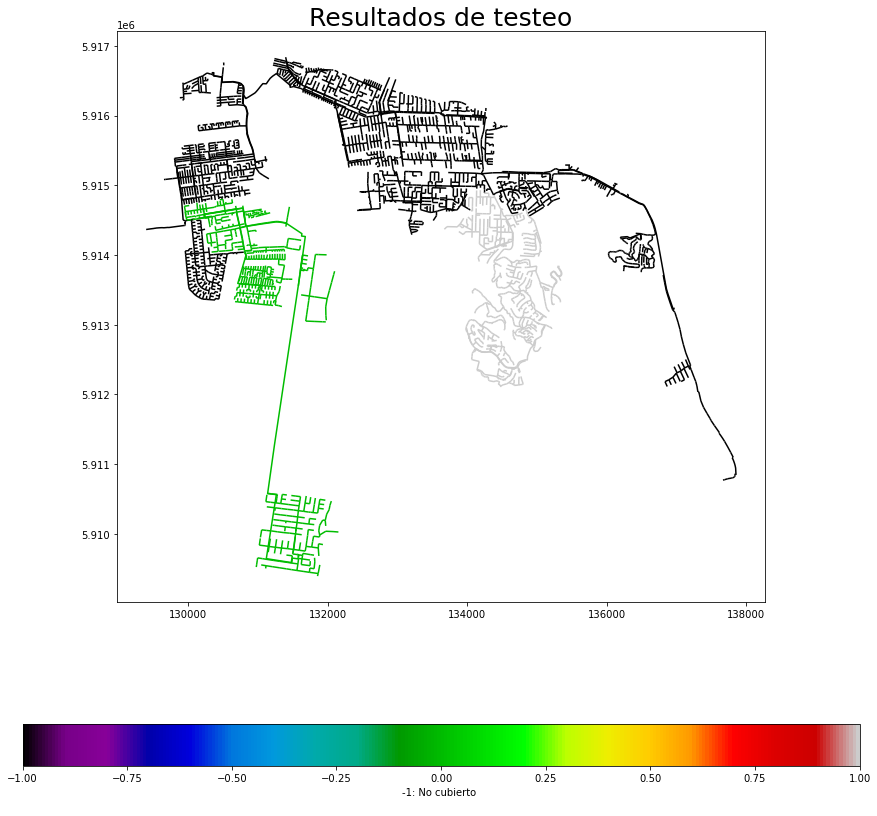

In [9]:
plot_sample_tree(G, N, [id_[15084], id_[13208]], geometry)

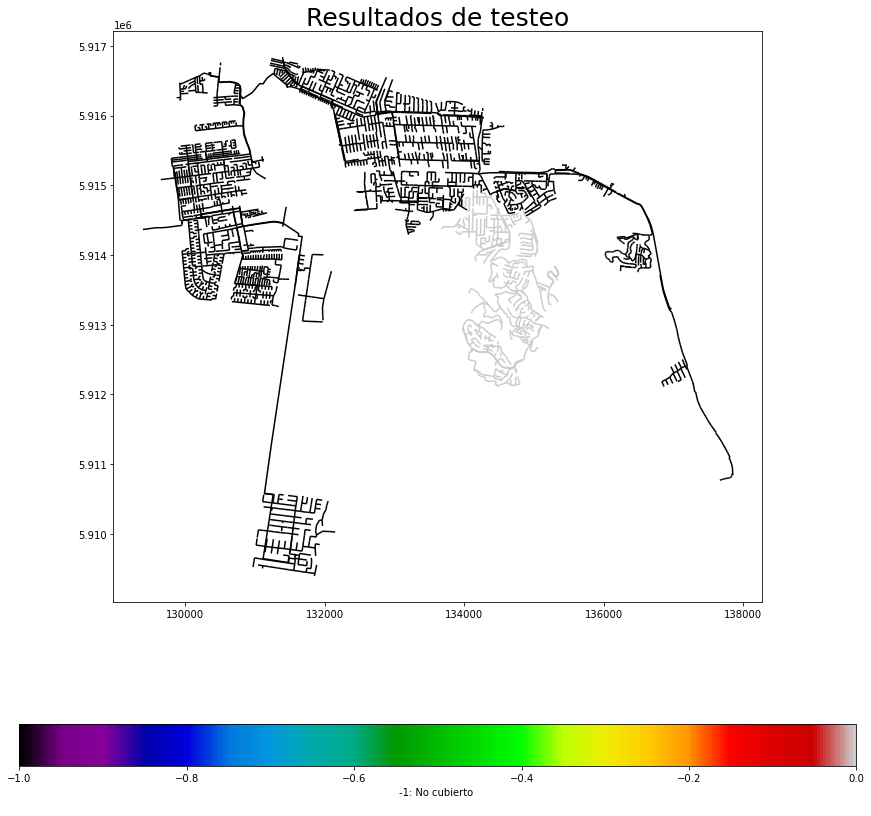

In [6]:
plot_sample_tree(G, N, [id_[15084]], geometry)

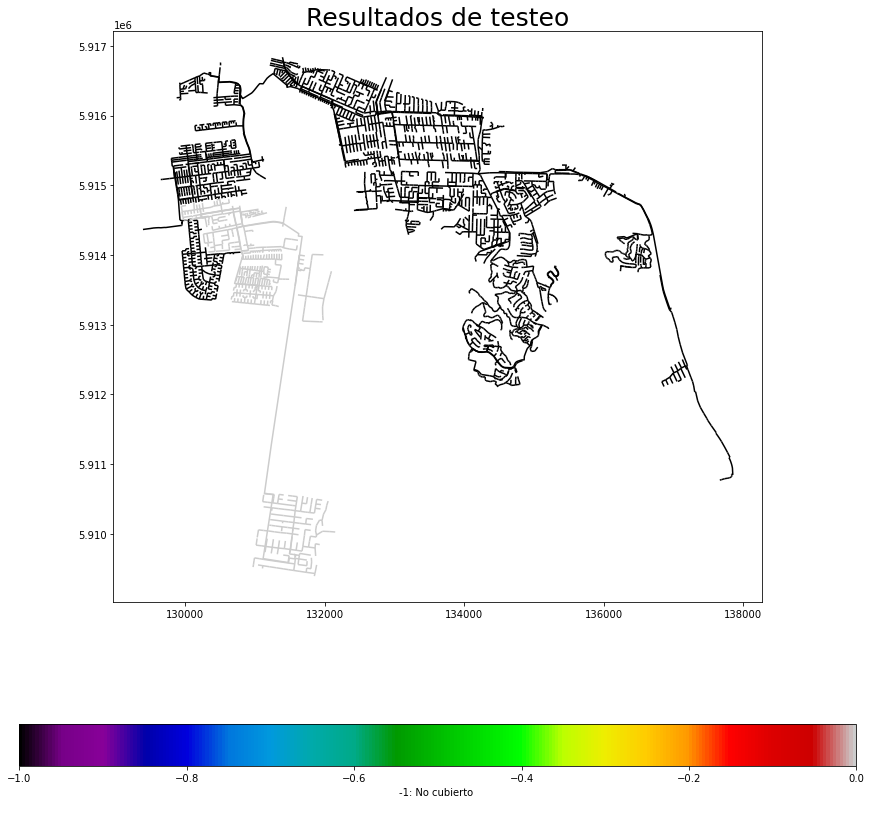

In [7]:
plot_sample_tree(G, N, [id_[13208]], geometry)

In [ ]:
root = # Nodo de planta (nodo de mayor ideal normal)

def get_size_robust(G, V_, node):
    
    N = len(V_)
    
    if V_[node]:
        return 0
    
    if node == root:
        return N - sum(V_)
    
    V = [0] * N
    
    V[root] = 1; Q = deque([root]);
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v != node:
                V[v] = 1
                Q.append(v)

    return sum([1 for u in range(N) if V_[u] + V[u] == 0])